# **Import các thư viện cần thiết**

In [1]:
# Pytorch
import torch
import pandas as pd
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

# Image Augumentation
import torchvision.transforms.functional as TF

# Data Visulization
import matplotlib.pyplot as plt

# OpenCV
import cv2

# Data processing
import os
import numpy as np
import random

# Splitting Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
#import thư viện để tải dataset được lưu săn trên google drive
import gdown

In [3]:
#Tải file ảnh được nén và giải nén
url = 'https://drive.google.com/uc?id=1k19UG07K7INFuuhXH6uNxEN4ybDFtaFo'
output = 'Faces.zip'
gdown.download(url, output, quiet=False)
!unzip Faces.zip

Downloading...
From: https://drive.google.com/uc?id=1k19UG07K7INFuuhXH6uNxEN4ybDFtaFo
To: /content/Faces.zip
100%|██████████| 13.2M/13.2M [00:00<00:00, 63.1MB/s]


Archive:  Faces.zip
   creating: Faces/
   creating: Faces/test_images/
  inflating: Faces/test_images/Akshay Kumar_48.jpg  
  inflating: Faces/test_images/Akshay Kumar_49.jpg  
  inflating: Faces/test_images/Alexandra Daddario_14.jpg  
  inflating: Faces/test_images/Alexandra Daddario_27.jpg  
  inflating: Faces/test_images/Alexandra Daddario_3.jpg  
  inflating: Faces/test_images/Alia Bhatt_41.jpg  
  inflating: Faces/test_images/Alia Bhatt_50.jpg  
  inflating: Faces/test_images/Alia Bhatt_56.jpg  
  inflating: Faces/test_images/Amitabh Bachchan_25.jpg  
  inflating: Faces/test_images/Amitabh Bachchan_31.jpg  
  inflating: Faces/test_images/Amitabh Bachchan_64.jpg  
  inflating: Faces/test_images/Andy Samberg_35.jpg  
  inflating: Faces/test_images/Andy Samberg_74.jpg  
  inflating: Faces/test_images/Andy Samberg_75.jpg  
  inflating: Faces/test_images/Anushka Sharma_27.jpg  
  inflating: Faces/test_images/Anushka Sharma_33.jpg  
  inflating: Faces/test_images/Anushka Sharma_48.jpg 

In [4]:
#Tải file train.csv
url2 = 'https://drive.google.com/uc?id=1WrS23VAZo4-5-tS-6gQfHmo_V1AcKPNQ'
output2 = 'train.csv'
gdown.download(url2, output2, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1WrS23VAZo4-5-tS-6gQfHmo_V1AcKPNQ
To: /content/train.csv
100%|██████████| 88.5k/88.5k [00:00<00:00, 25.3MB/s]


'train.csv'

In [5]:
#Tải file test.csv
url3 = 'https://drive.google.com/uc?id=1ndSg3z6I1QpZhVeGR5A0s8Kkn6JJ2FkV'
output3 = 'test.csv'
gdown.download(url3, output3, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ndSg3z6I1QpZhVeGR5A0s8Kkn6JJ2FkV
To: /content/test.csv
100%|██████████| 2.19k/2.19k [00:00<00:00, 8.75MB/s]


'test.csv'

In [6]:
csv_train_file_path='./train.csv'
csv_test_file_path='./test.csv'
file_path='./Faces/train_images'
images_name=os.listdir(file_path)
images_name[:5]

['Anushka Sharma_17.jpg',
 'Priyanka Chopra_98.jpg',
 'Alia Bhatt_47.jpg',
 'Jessica Alba_38.jpg',
 'Jessica Alba_39.jpg']

**Data Augmentation:**

Tăng cường dữ liệu bằng các thao tác trên tập ảnh có sẵn như lật ngang, lật dọc, xoay hình, ...

In [7]:
# data_transforms cho việc tăng cường dữ liệu
training_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.Resize((224,224),antialias=True),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30)]
)
valid_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.Resize((224,224),antialias=True)]
)

Minh họa Data Augmentation trên ảnh

In [8]:
#thư việc hỗ trợ đọc ảnh thuận tiên hợn
from PIL import Image

(-0.5, 159.5, 159.5, -0.5)

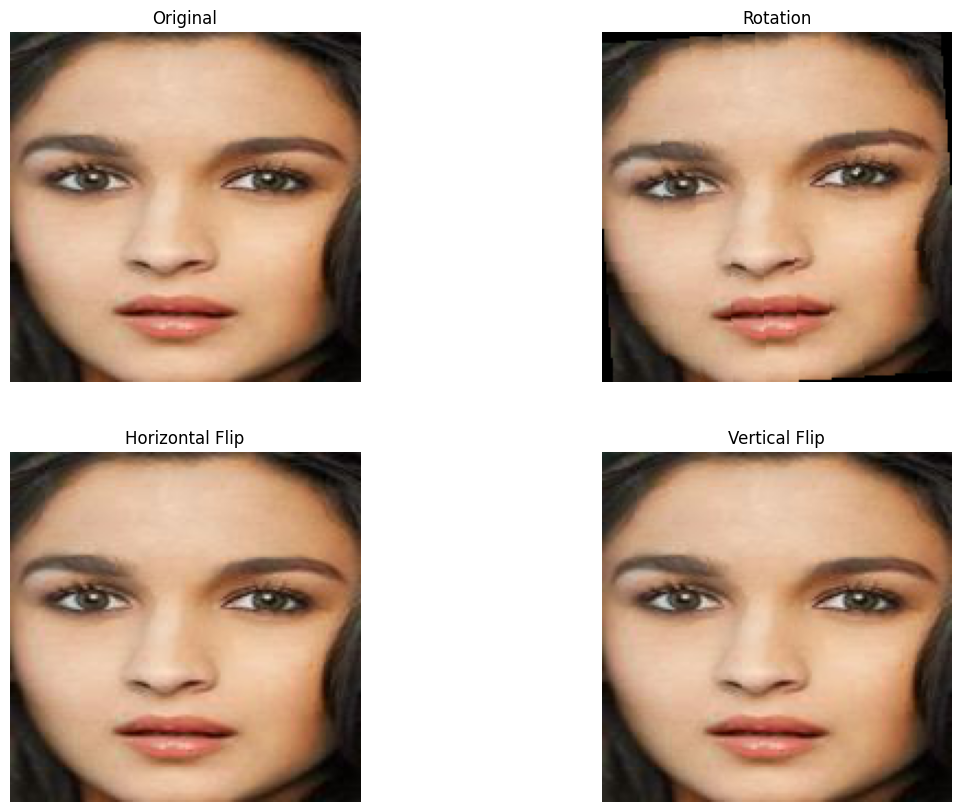

In [9]:
img_face = Image.open('./Faces/train_images/Alia Bhatt_4.jpg').convert('RGB')

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)

# Ảnh gốc.
plt.imshow(img_face)
plt.title(f"Original", fontsize=12)
plt.axis("off")

# Xoay 45 độ.
plt.subplot(2, 2, 2)
img_rotation = transforms.RandomRotation(degrees= 45)(img_face)
plt.imshow(img_rotation)
plt.title(f"Rotation", fontsize=12)
plt.axis("off")

# lật ảnh theo chiều ngang.
plt.subplot(2, 2, 3)
img_horizon = transforms.RandomHorizontalFlip()(img_face)
plt.imshow(img_horizon)
plt.title(f"Horizontal Flip", fontsize=12)
plt.axis("off")

# Lật ảnh theo chiều dọc.
plt.subplot(2, 2, 4)
img_vertical = transforms.RandomVerticalFlip()(img_face)
plt.imshow(img_vertical)
plt.title(f"Vertical Flip", fontsize=12)
plt.axis("off")

**Xây dựng một lớp custom dataset cho việc load dữ liệu**

In [10]:
df=pd.read_csv('./train.csv')
classes=list(set(list(df['label'].values)))
classes=sorted(classes)

In [11]:
class MyDataset(Dataset):
    def __init__(self, file_path, df,classes,transforms=None, training=True):
        self.df = df
        self.classes=classes
        self.transforms = transforms
        self.training = training
        self.Path_to_image=file_path
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_path = self.Path_to_image + '/' + self.df.loc[idx, 'id']
        img = Image.open(img_path).convert('RGB')
        if self.training:
            labels = self.df.loc[idx,self.df.columns[1]]
            labels = self.classes.index(labels)
            labels =torch.as_tensor(labels, dtype=torch.int8)
            if self.transforms:
                img = self.transforms(img)
            return img, labels
        else:
            if self.transforms:
                img = self.transforms(img)
            return img
        return img

# **Xây dựng kiến trúc mạng VGG16 và RESNET50**

**Xây dựng model và tiến hành training**

In [12]:
def get_model(num_classes, name_model):
    assert name_model == 'resnet50' or name_model == 'vgg16'
    if name_model == 'vgg16':
        model = models.vgg16(pretrained = True)
        in_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_features= in_features, out_features=num_classes)
        return model
    else:
        model = models.resnet50(pretrained= True)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features=in_features, out_features=num_classes)
        return model

def train_model(model,
                name_model, 
                training_data_loader, 
                valid_data_loader, 
                critertion,
                optimizer,
                num_epochs = 5,
                device = None):
    min_loss = np.inf
    valid_loss_history = []
    valid_acc_history = []
    training_loss_history = []
    training_acc_history = []
    
    for epoch in range(1, num_epochs + 1):
        print("Epoch %d/%d: " %(epoch, num_epochs))
        training_loss = 0
        valid_loss = 0
        running_loss = 0
        model.train()
        step = 1
        preds_accuracy = []
        labels_accuracy = []
        for images, labels in training_data_loader:
            if device is not None:
                images = images.to(device)
                labels = labels.type(torch.LongTensor)  
                labels = labels.to(device)
                
            #Dự đoán bằng model
            predictions = model(images)

            #Xóa bộ nhớ gradient của Pytorch
            optimizer.zero_grad()
            
            #Tính chi phí Loss 
            training_loss_step =  critertion(predictions, labels)
            training_loss_step.backward()

            #Cập nhật tham số bằng gradient descent trong Pytorch
            optimizer.step()
            training_loss  += training_loss_step.item()
            running_loss = training_loss/step
            step +=1

            labels_accuracy = np.concatenate((labels_accuracy, labels.cpu().numpy()), 0)
            preds_accuracy = np.concatenate((preds_accuracy, np.argmax(predictions.cpu().detach().numpy(), 1)), 0)
        
        training_loss_history.append(training_loss)
        training_accuracy = accuracy_score(labels_accuracy, preds_accuracy)
        training_acc_history.append(training_accuracy)
        print("Training loss: %.3f  Accuracy: %.3f" %(training_loss, training_accuracy))

        step =1 # reset step for validation
        preds_accuracy = []
        labels_accuracy = []
        model.eval() # Gọi hàm đánh giá của model

        #Trong bước đánh giá không cần thực hiện gradient descent để cập nhật tham số
        #Do đó không cần gọi đến grad() của Pytorch
        with torch.no_grad():
            for images, labels in valid_data_loader:
                if device is not None:
                    images = images.to(device)
                    labels = labels.type(torch.LongTensor)
                    labels = labels.to(device)
                
                
                predictions = model(images)
                valid_loss_step = critertion(predictions, labels)
                valid_loss += valid_loss_step.item()

                running_loss = valid_loss/step
                step+=1
                labels_accuracy = np.concatenate((labels_accuracy, labels.cpu().numpy()), 0)
                preds_accuracy = np.concatenate((preds_accuracy, np.argmax(predictions.cpu().detach().numpy(), 1)), 0)

        valid_loss_history.append(valid_loss)
        valid_accuracy = accuracy_score(labels_accuracy, preds_accuracy)
        valid_acc_history.append(valid_accuracy)
        print("Valid loss: %.3f     Accuracy: %.3f" % (valid_loss, valid_accuracy))
        if valid_loss <= min_loss:
            min_loss = valid_loss
            if name_model=='vgg16':
                torch.save(model.state_dict(),'./face_vgg16.pth')
            else:
                torch.save(model.state_dict(),'./face_resnet50.pth')
            print("Model save with %.3f loss at Epoch %d" % (min_loss, epoch))
        print('\n===========================================================')
        print("Complete epoch %d/%d     Training loss: %.3f     Trainning accuracy: %.3f   Valid loss: %.3f    Valid accuracy: %.3f"\
                        %(epoch, num_epochs, training_loss,training_accuracy, valid_loss, valid_accuracy))
        print('============================================================')

    return training_loss_history,training_acc_history, valid_loss_history,valid_acc_history 

Đọc dữ liệu từ file 'train.csv' để làm đầu vào cho lớp MyDataset

In [13]:
train_df = pd.read_csv(csv_train_file_path)

In [14]:
training_data, valid_data = train_test_split(train_df,test_size=0.3, random_state=82)

In [15]:
training_data.reset_index(drop=True, inplace=True)
valid_data.reset_index(drop=True, inplace=True)

In [16]:
training_dataset = MyDataset(file_path, training_data, classes,transforms= training_transforms, training=True)
valid_dataset = MyDataset(file_path, valid_data, classes,transforms=valid_transforms, training=True)

In [17]:
training_data_loader = DataLoader(training_dataset, batch_size=16)
valid_data_loader = DataLoader(valid_dataset, batch_size=8)

In [18]:
#Tạo khung cho model vgg16
model_vgg16 = get_model(num_classes = 31, name_model='vgg16')
model_vgg16.eval()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_vgg16.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 255MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
#Tạo khung cho model resnet50
model_resnet50 = get_model(num_classes = 31, name_model='resnet50')
model_resnet50.eval()
device2 = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_resnet50.to(device2)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 260MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
url_vgg16 = 'https://drive.google.com/uc?id=18VwM7EjlsYHddz9Wor_SMG6zdL68IfxO'
output_vgg16 = 'face_vgg16.pth'
gdown.download(url_vgg16, output_vgg16, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=18VwM7EjlsYHddz9Wor_SMG6zdL68IfxO
To: /content/face_vgg16.pth
100%|██████████| 538M/538M [00:03<00:00, 139MB/s]


'face_vgg16.pth'

In [21]:
url_resnet50 = 'https://drive.google.com/uc?id=1oJrv4ObIoxQX5V3f7Tzp7w3pg5gsqOTk'
output_resnet50 = 'face_resnet50.pth'
gdown.download(url_resnet50, output_resnet50, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1oJrv4ObIoxQX5V3f7Tzp7w3pg5gsqOTk
To: /content/face_resnet50.pth
100%|██████████| 94.6M/94.6M [00:00<00:00, 135MB/s]


'face_resnet50.pth'

In [22]:
#Tải mô hình đã được pre-trained sẵn bộ tham số tối ưu vào các khung vừa tạo phía trên
if torch.cuda.is_available():
    model_vgg16.load_state_dict(torch.load('./face_vgg16.pth'))
    model_resnet50.load_state_dict(torch.load('./face_resnet50.pth'))
else:
    model_resnet50.load_state_dict(torch.load('./face_resnet50.pth', map_location=torch.device('cpu')))
    model_vgg16.load_state_dict(torch.load('./face_vgg16.pth', map_location=torch.device('cpu')))

In [25]:
optimizer_vgg16 = optim.Adam(model_vgg16.parameters(), lr = 0.0001)
optimizer_resnet50 = optim.Adam(model_resnet50.parameters(), lr = 0.0001)
critertion = nn.CrossEntropyLoss()
num_epochs = 40

# **Huấn luyện mô hình VGG16:**

In [26]:
history_vgg16 = train_model(model_vgg16,
                            'vgg16', 
                            training_data_loader, 
                            valid_data_loader,
                            critertion,
                            optimizer_vgg16,
                            num_epochs,
                            device)

Epoch 1/40: 
Training loss: 123.159  Accuracy: 0.617
Valid loss: 87.238     Accuracy: 0.685
Model save with 87.238 loss at Epoch 1

Complete epoch 1/40     Training loss: 123.159     Trainning accuracy: 0.617   Valid loss: 87.238    Valid accuracy: 0.685
Epoch 2/40: 
Training loss: 96.231  Accuracy: 0.702
Valid loss: 76.249     Accuracy: 0.719
Model save with 76.249 loss at Epoch 2

Complete epoch 2/40     Training loss: 96.231     Trainning accuracy: 0.702   Valid loss: 76.249    Valid accuracy: 0.719
Epoch 3/40: 
Training loss: 84.996  Accuracy: 0.730
Valid loss: 88.985     Accuracy: 0.714

Complete epoch 3/40     Training loss: 84.996     Trainning accuracy: 0.730   Valid loss: 88.985    Valid accuracy: 0.714
Epoch 4/40: 
Training loss: 75.329  Accuracy: 0.777
Valid loss: 74.650     Accuracy: 0.739
Model save with 74.650 loss at Epoch 4

Complete epoch 4/40     Training loss: 75.329     Trainning accuracy: 0.777   Valid loss: 74.650    Valid accuracy: 0.739
Epoch 5/40: 
Training los

# **Đánh giá cho mô hình VGG16:**

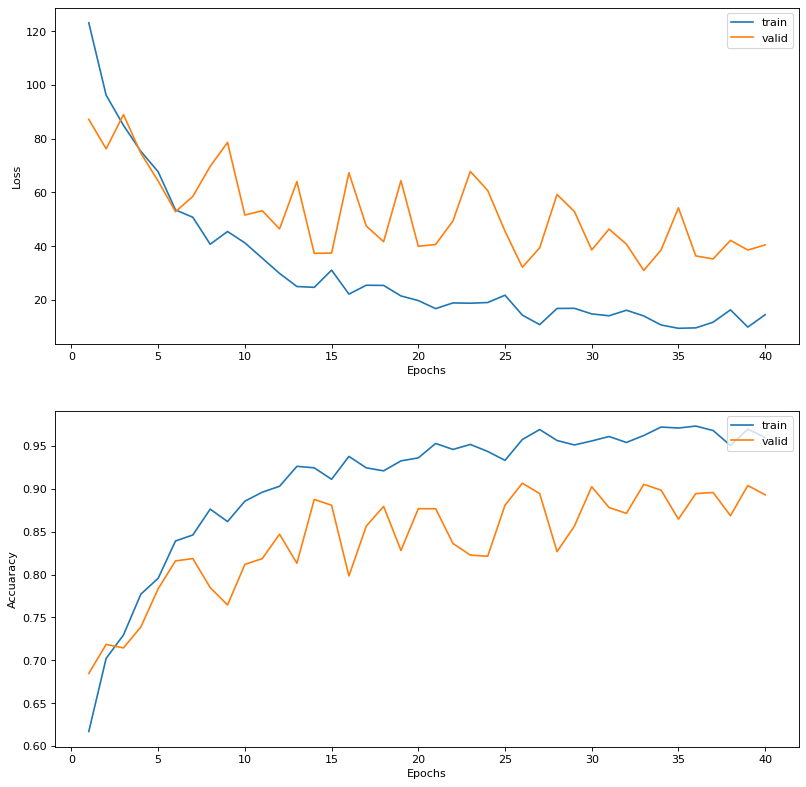

In [27]:
loss, acc, val_loss, val_acc = history_vgg16
plt.figure(figsize=(12, 12), dpi=80)
plt.subplot(2,1,1)
plt.plot([i for i in range(1,len(loss)+1)],loss)
plt.plot([i for i in range(1,len(loss)+1)], val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'valid'], loc='upper right')

plt.subplot(2,1,2)
plt.plot([i for i in range(1,len(loss)+1)],acc)
plt.plot([i for i in range(1,len(loss)+1)], val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuaracy')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

# **Huấn luyện mô hình RESNET50:**

In [28]:
history_resnet50 = train_model(model_resnet50,
                               'resnet50', 
                               training_data_loader, 
                               valid_data_loader,
                               critertion,
                               optimizer_resnet50,
                               num_epochs,
                               device)

Epoch 1/40: 
Training loss: 265.215  Accuracy: 0.344
Valid loss: 138.275     Accuracy: 0.647
Model save with 138.275 loss at Epoch 1

Complete epoch 1/40     Training loss: 265.215     Trainning accuracy: 0.344   Valid loss: 138.275    Valid accuracy: 0.647
Epoch 2/40: 
Training loss: 121.598  Accuracy: 0.708
Valid loss: 74.653     Accuracy: 0.769
Model save with 74.653 loss at Epoch 2

Complete epoch 2/40     Training loss: 121.598     Trainning accuracy: 0.708   Valid loss: 74.653    Valid accuracy: 0.769
Epoch 3/40: 
Training loss: 63.441  Accuracy: 0.849
Valid loss: 57.124     Accuracy: 0.816
Model save with 57.124 loss at Epoch 3

Complete epoch 3/40     Training loss: 63.441     Trainning accuracy: 0.849   Valid loss: 57.124    Valid accuracy: 0.816
Epoch 4/40: 
Training loss: 38.292  Accuracy: 0.921
Valid loss: 41.292     Accuracy: 0.851
Model save with 41.292 loss at Epoch 4

Complete epoch 4/40     Training loss: 38.292     Trainning accuracy: 0.921   Valid loss: 41.292    Val

# **Đánh giá cho mô hình RESNET50:**

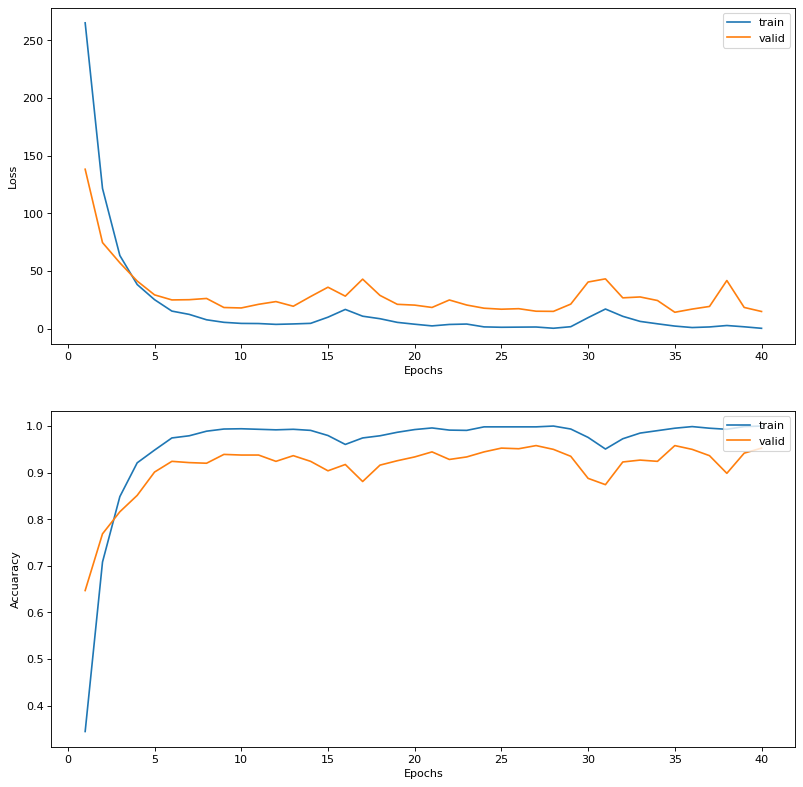

In [29]:
loss, acc, val_loss, val_acc = history_resnet50
plt.figure(figsize=(12, 12), dpi=80)
plt.subplot(2,1,1)
plt.plot([i for i in range(1,len(loss)+1)],loss)
plt.plot([i for i in range(1,len(loss)+1)], val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'valid'], loc='upper right')

plt.subplot(2,1,2)
plt.plot([i for i in range(1,len(loss)+1)],acc)
plt.plot([i for i in range(1,len(loss)+1)], val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuaracy')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

# **Nhận dạng trên tập test:**

In [30]:
test_df=pd.read_csv(csv_test_file_path)

In [31]:
file_test_path='./Faces/test_images'

In [32]:
test_dataset= MyDataset(file_test_path, test_df, classes,transforms=valid_transforms, training=False)
test_data_loader = DataLoader(test_dataset, batch_size= 32)

## **Nhận dạng bằng model VGG16:**

In [33]:
result =pd.DataFrame()
for imgs in test_data_loader:
    imgs = imgs.to(device)
    predictions = model_vgg16(imgs)
    score = nn.Softmax(1)(predictions).detach().cpu().numpy()
    label= [classes[i] for i in np.argmax(score,axis=1)]
    output = pd.DataFrame(label, columns=['label'])
    result = pd.concat([result, output], ignore_index=True)

submission_df = result.copy()
submission_df['id'] = test_df.id
submission_df = submission_df[['id','label']]

submission_df.to_csv('submission-faces-recognition-vgg16.csv', index=False)

## **Nhận dạng bằng model RESNET50:**

In [34]:
result =pd.DataFrame()
for imgs in test_data_loader:
    imgs = imgs.to(device)
    predictions = model_resnet50(imgs)
    score = nn.Softmax(1)(predictions).detach().cpu().numpy()
    label= [classes[i] for i in np.argmax(score,axis=1)]
    output = pd.DataFrame(label, columns=['label'])
    result = pd.concat([result, output], ignore_index=True)

submission_df = result.copy()
submission_df['id'] = test_df.id
submission_df = submission_df[['id','label']]

submission_df.to_csv('submission-faces-recognition-resnet50.csv', index=False)

# **Tổng kết:**

- Cả hai mô hình đều cho kết quả rất khả quan trên tác vụ nhận diện khuôn mặt này.
- **Với mô hình VGG16:**
  + Train Loss = 14.033.
  + Train Accuracy đạt 96.2%.
  + Validation Loss = 30.976.
  + Validation Accuracy đạt 90.5%.
- **Với mô hình ResNet50:**
  + Train Loss = 2.256.
  + Train Accuracy đạt 99.5%.
  + Validation Loss = 14.232.
  + Validation Accuracy đạt 95.8%.